<a href="https://colab.research.google.com/github/GuyRobot/AINotesBook/blob/main/ImageClassifyKaggle25GB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from google.colab import files
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
drive_mount_path = "/content/data"
drive.mount(drive_mount_path)

Mounted at /content/data


In [3]:
!mkdir ~/.kaggle
!cp "/content/data/MyDrive/.kaggle/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Info on how to get your api key (kaggle.json) here: https://github.com/Kaggle/kaggle-api#api-credentials
!pip install kaggle
!mkdir /content/datasets/
!cd /content/datasets && kaggle datasets download -d gpiosenka/100-bird-species
# !kaggle config set -n path -v /content/datasets


 99% 1.60G/1.62G [00:49<00:00, 33.1MB/s]
100% 1.62G/1.62G [00:49<00:00, 35.0MB/s]


In [4]:
path = "/content/datasets"
os.chdir(path)
for file in os.listdir(path):
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()


In [5]:
train_data_dir = pathlib.Path(os.path.join(path, "train"))
valid_data_dir = pathlib.Path(os.path.join(path, "valid"))
test_data_dir = pathlib.Path(os.path.join(path, "test"))

image_count = len(list(train_data_dir.glob('*/*.jpg')))
print(image_count)

36609


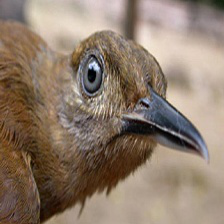

In [6]:
ant_birds = list(train_data_dir.glob('ANTBIRD/*'))
PIL.Image.open(str(ant_birds[0]))

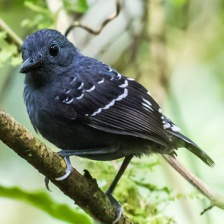

In [7]:
PIL.Image.open(str(ant_birds[2]))

In [8]:
# Datasets
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [9]:
train_datasets = tf.keras.preprocessing.image_dataset_from_directory(train_data_dir, 
                                                                     image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                                     batch_size=BATCH_SIZE)

Found 36609 files belonging to 260 classes.


In [10]:
valid_datasets = tf.keras.preprocessing.image_dataset_from_directory(valid_data_dir,
                                                                     image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                                     batch_size=BATCH_SIZE)


Found 1300 files belonging to 260 classes.


In [11]:
class_names = train_datasets.class_names
class_names

['AFRICAN CROWNED CRANE',
 'AFRICAN FIREFINCH',
 'ALBATROSS',
 'ALEXANDRINE PARAKEET',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'ANHINGA',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ARARIPE MANAKIN',
 'ASIAN CRESTED IBIS',
 'BALD EAGLE',
 'BALI STARLING',
 'BALTIMORE ORIOLE',
 'BANANAQUIT',
 'BANDED BROADBILL',
 'BAR-TAILED GODWIT',
 'BARN OWL',
 'BARN SWALLOW',
 'BARRED PUFFBIRD',
 'BAY-BREASTED WARBLER',
 'BEARDED BARBET',
 'BELTED KINGFISHER',
 'BIRD OF PARADISE',
 'BLACK FRANCOLIN',
 'BLACK SKIMMER',
 'BLACK SWAN',
 'BLACK TAIL CRAKE',
 'BLACK THROATED WARBLER',
 'BLACK VULTURE',
 'BLACK-CAPPED CHICKADEE',
 'BLACK-NECKED GREBE',
 'BLACK-THROATED SPARROW',
 'BLACKBURNIAM WARBLER',
 'BLUE GROUSE',
 'BLUE HERON',
 'BOBOLINK',
 'BROWN NOODY',
 'BROWN THRASHER',
 'CACTUS WREN',
 'CALIFORNIA CONDOR',
 'CALIFORNIA GULL',
 'CALIFORNIA QUAIL',
 'CANARY',
 'CAPE MAY WARBLER',
 'CAPUCHINBIRD',
 'C

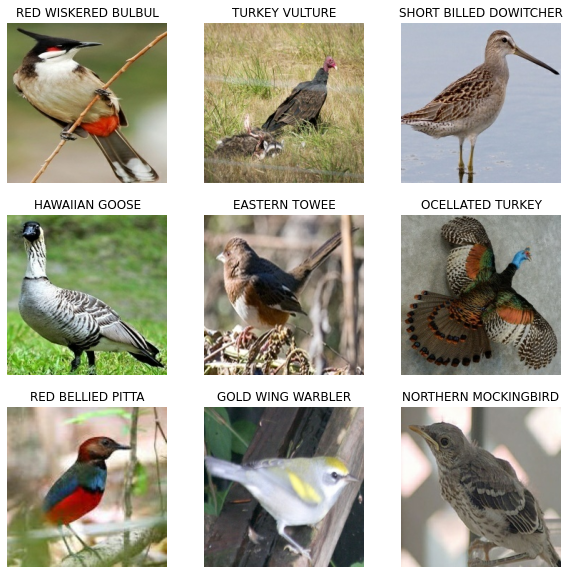

In [12]:
plt.figure(figsize=(10, 10))

for images, labels in train_datasets.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
for image_batch, labels_batch in train_datasets:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_datasets = train_datasets.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_datasets = valid_datasets.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

In [17]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)       

In [ ]:
epochs = 15
history = model.fit(
  train_datasets,
  validation_data=valid_datasets,
  epochs=epochs
)

Epoch 1/15
1145/1145 [==============================] - 103s 30ms/step - loss: 4.9942 - accuracy: 0.0551 - val_loss: 3.4511 - val_accuracy: 0.2338
Epoch 2/15
1145/1145 [==============================] - 22s 19ms/step - loss: 3.2291 - accuracy: 0.2805 - val_loss: 2.4030 - val_accuracy: 0.4338
Epoch 3/15
1145/1145 [==============================] - 22s 19ms/step - loss: 2.5948 - accuracy: 0.4032 - val_loss: 2.0598 - val_accuracy: 0.5100
Epoch 4/15
1145/1145 [==============================] - 22s 19ms/step - loss: 2.2539 - accuracy: 0.4627 - val_loss: 1.8337 - val_accuracy: 0.5538
Epoch 5/15
1145/1145 [==============================] - 22s 19ms/step - loss: 2.0594 - accuracy: 0.5028 - val_loss: 1.6420 - val_accuracy: 0.5823
Epoch 6/15
1145/1145 [==============================] - 22s 19ms/step - loss: 1.9001 - accuracy: 0.5375 - val_loss: 1.6729 - val_accuracy: 0.5969
Epoch 7/15
1145/1145 [==============================] - 22s 19ms/step - loss: 1.7771 - accuracy: 0.5616 - val_loss: 1.5120 